# Capstone Project - The Battle of Neighborhoods


### Importing libraries


In [1]:
import numpy as np #library to handle data in vectorized manner
import pandas as pd #library to convert teh data in tabular form and perform data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json #libraryto handle JSOn files
!pip install geocoder
import geocoder
from geopy.geocoders import Nominatim #convert an address into latitude and longitude values. 
import requests #library to handle requests
from bs4 import BeautifulSoup #library for pulling data from HTML and XML files


In [2]:
# library matplotlib and its associated modules for plotting
import matplotlib.pyplot as plt  
import matplotlib.cm as cm    
import matplotlib.colors as colors
!pip install folium
import folium # library to visualize the data on the map 
import seaborn as sns # Data visualization library for drawing statistcial graphics

#import k-means from clustering stage 
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
print('Libraries imported')

Libraries imported


#  1. Data Preparation
For the Vancouver neighbourhood data, a [Wikipedia page](@https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Vancouver) exists that has all the information that can be used to explore and cluster the 20 official neighbourhoods in the city of Vancouver. The corresponding coordinates are obtained using geocoder. 


### A. Scrapping content form Wikipedia page

In [3]:
def getNeighborhood():
    #download the data and parse it
    request = requests.get("https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Vancouver") 
    neighborhoods = BeautifulSoup(request.text)
    # find all the items
    items = neighborhoods.find_all("li")
    # make a dictionary of the all the text
    dict0 = {}
    for i in range(8,29):
        try:
            dict0["Neighborhood"].append(items[i].text)
        except:
            dict0["Neighborhood"] = []
    # make a dataframe of all the items in dictionary 
    return pd.DataFrame(dict0)


In [4]:
#scrap data from open-source databases
neighborhoods = getNeighborhood()
print("-finished scrapping all neighborhoods")
# print the total neighborhoods and display the dataframe 
print("There are total {} neighborhoods in the city of Vancouver".format(neighborhoods.shape[0]))
neighborhoods

-finished scrapping all neighborhoods
There are total 20 neighborhoods in the city of Vancouver


,Neighborhood
0,Grandview-Woodland - A mature neighbourhood in...
1,Hastings-Sunrise - One of Vancouver's oldest n...
2,Kensington-Cedar Cottage - One of the most mul...
3,Kerrisdale - A primarily residential neighbour...
4,Killarney - Located in the southeastern corner...
5,Kitsilano - Located along the south end of Eng...
6,Marpole - The neighbourhood contains a diverse...
7,"Mount Pleasant - Known for its unusual stores,..."
8,Oakridge - Known for being the location of Oak...
9,"Renfrew-Collingwood - A large, primarily resid..."


There are a total of 20 neighborhoods in Vancouver. Notice that  the list is displaying the name of neighborhood and their description. I am keeping just the name of the neighborhood without any other text or description in the dataframe.

In [5]:
neighborhoods["Neighborhood"] = neighborhoods["Neighborhood"].str.split(" -", 1, expand = True) 
neighborhoods["Neighborhood"] = neighborhoods["Neighborhood"].str.split(" is", 1, expand = True)
neighborhoods

,Neighborhood
0,Grandview-Woodland
1,Hastings-Sunrise
2,Kensington-Cedar Cottage
3,Kerrisdale
4,Killarney
5,Kitsilano
6,Marpole
7,Mount Pleasant
8,Oakridge
9,Renfrew-Collingwood


It looks much cleaner now. We have the names of 20 neighborhoods in Vancouver. Let's get the latitude and longitude coordinates of each neighborhood using geocoder. 

### B. Get the latitude and the longitude coordinates of each neighborhood

In [6]:
def get_latlng(neighborhood):
    #initialize your variable to none
    lat_lng_coords = None
    #loop untill you get the coordinates
    while (lat_lng_coords is None):
        g = geocoder.arcgis('{}, Vancouver, Canada'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords



In [7]:
# get the coordinates for neighborhood listed in dataframe
coords = [get_latlng(neighborhood) for neighborhood in neighborhoods["Neighborhood"].to_list()]
print("Finished scrapping coordinates for all neighborhoods")

Finished scrapping coordinates for all neighborhoods


In [8]:
# concatenate the coordinates in the dataframe
neighborhoods = pd.concat([neighborhoods, pd.DataFrame(columns = ["Latitude", "Longitude"], data = coords)], axis =1)
neighborhoods

,Neighborhood,Latitude,Longitude
0,Grandview-Woodland,49.28296,-123.06934
1,Hastings-Sunrise,49.28021,-123.02869
2,Kensington-Cedar Cottage,49.24973,-123.06986
3,Kerrisdale,49.22097,-123.15073
4,Killarney,49.22670,-123.03657
5,Kitsilano,49.26833,-123.16542
6,Marpole,49.20067,-123.13053
7,Mount Pleasant,49.26178,-123.09608
8,Oakridge,49.23004,-123.12117
9,Renfrew-Collingwood,49.24970,-123.02975


## 2. Exploratory Data Analysis and Data Preprocessing


### A. Geographical coordnates of Vancouver

In [9]:
address = 'Vancouver, BC, Canada'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Vancouver, BC, Canada are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Vancouver, BC, Canada are 49.2608724, -123.1139529.


### B. Visualize a map of Vancouver with neighbourhoods

In [10]:
# create map of Vancouver using latitude and longitude values
map_Vancouver = folium.Map(location = [latitude, longitude], zoom_start=10)

#add makers to map 
for lat, lng, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods["Neighborhood"]):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
            [lat, lng],
            radius = 5,
            popup = label,
            color = 'blue',
            fill = True,
            fill_color = '#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_Vancouver)

map_Vancouver

Now we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them. 

### C. Geospatial data from Foursquare

In [11]:
# The code was removed by Watson Studio for sharing.

### D. Show top 100 venues in each neighborhoods within a radius of 500 meters

In [12]:
# Get top 100 venues that are in each neighborhoods within a rdaius of 500 meters 
LIMIT = 100 # limit the number of venues returned by Foursquare API
radius = 500 # define radius in meters

def get_nearby_venues(names, latitudes, longitudes, radius=500):
    venues_list =[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        #create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        #return only relevant information for each nearby venue
        venues_list.append([(
        name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Vancouver_venues = get_nearby_venues(names=neighborhoods['Neighborhood'],
                                  latitudes =neighborhoods['Latitude'],
                                  longitudes = neighborhoods['Longitude']
                                  )
Vancouver_venues.shape

Grandview-Woodland
Hastings-Sunrise
Kensington-Cedar Cottage
Kerrisdale
Killarney
Kitsilano
Marpole
Mount Pleasant
Oakridge
Renfrew-Collingwood
Riley Park
Shaughnessy
South Cambie
Strathcona
Sunset
Victoria-Fraserview
West End
West Point Grey
Yaletown
Coal Harbour


(562, 7)

### E. Exploration of most common restaurants in Vancouver

In [13]:
# Create a Data-Frame out of it to concentrate only on Restaurants 
Vancouver_Venues_only_restaurant = Vancouver_venues[Vancouver_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
Vancouver_Venues_only_restaurant.index = np.arange(1, len(Vancouver_Venues_only_restaurant )+1)

print(Vancouver_Venues_only_restaurant['Venue Category'].value_counts())

Sushi Restaurant                   21
Restaurant                         15
Japanese Restaurant                14
Ramen Restaurant                   12
Vietnamese Restaurant               9
Chinese Restaurant                  9
Italian Restaurant                  7
Indian Restaurant                   7
Vegetarian / Vegan Restaurant       6
Malay Restaurant                    6
Seafood Restaurant                  6
Fast Food Restaurant                5
Middle Eastern Restaurant           5
Korean Restaurant                   5
French Restaurant                   4
Asian Restaurant                    4
Greek Restaurant                    4
Cantonese Restaurant                3
Thai Restaurant                     3
Mexican Restaurant                  3
Tapas Restaurant                    2
Ethiopian Restaurant                2
Lebanese Restaurant                 1
American Restaurant                 1
Latin American Restaurant           1
South Indian Restaurant             1
Falafel Rest

In [14]:
print('There are {} unique categories.'.format(len(Vancouver_Venues_only_restaurant['Venue Category'].unique())))

There are 36 unique categories.


In [15]:
# create a dataframe of top 10 categories
Vancouver_Venues_Top10 = Vancouver_Venues_only_restaurant['Venue Category'].value_counts()[0:10].to_frame(name='frequency')
Vancouver_Venues_Top10 = Vancouver_Venues_Top10.reset_index()
Vancouver_Venues_Top10.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
Vancouver_Venues_Top10

,Venue_Category,Frequency
0,Sushi Restaurant,21
1,Restaurant,15
2,Japanese Restaurant,14
3,Ramen Restaurant,12
4,Vietnamese Restaurant,9
5,Chinese Restaurant,9
6,Italian Restaurant,7
7,Indian Restaurant,7
8,Vegetarian / Vegan Restaurant,6
9,Malay Restaurant,6


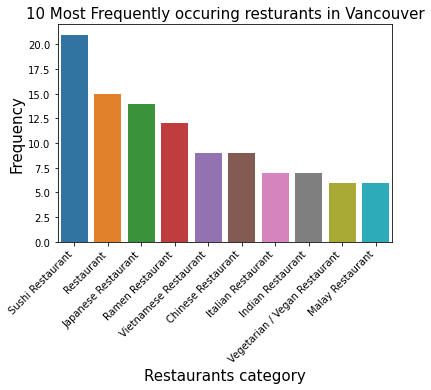

<Figure size 1296x504 with 0 Axes>

In [16]:
s=sns.barplot(x="Venue_Category", y="Frequency", data=Vancouver_Venues_Top10)
s.set_xticklabels(s.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('10 Most Frequently occuring resturants in Vancouver', fontsize=15)
plt.xlabel("Restaurants category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues1.png", dpi=300)
fig = plt.figure(figsize=(18,7))
plt.show()

Restaurants serving Sushi are the winners in the list of top most frequently occuring restaurants in Vancouver. As my project is looking more for Vegetarian/Vegan restaurants or Indian or Italian restaurants, I am amazed to see theses cuisine in the top 10 list of restaurants. While this is interesting, I would like to dig deeper to know which neighborhoods have the higher number of aforementioned cuisines.

### F. Analysis of the neighborhoods

In [17]:
print("Shape of the DataFrame with Venue Category only restaurant: ", Vancouver_Venues_only_restaurant.shape)

Shape of the DataFrame with Venue Category only restaurant:  (166, 7)


In [18]:
Vancouver_Venues_restaurant = Vancouver_Venues_only_restaurant.groupby(['Neighborhood'])['Venue Category'].apply(lambda x: x[x.str.contains('Restaurant')].count())

In [19]:
Vancouver_Venues_restaurant.sort_values(ascending=True, inplace=True)
Vancouver_Venues_restaurant

Neighborhood
Kerrisdale                   1
Renfrew-Collingwood          1
Marpole                      2
Victoria-Fraserview          2
Strathcona                   3
Kensington-Cedar Cottage     5
Shaughnessy                  5
Hastings-Sunrise             6
South Cambie                 6
Oakridge                     7
Grandview-Woodland           7
Kitsilano                    9
Mount Pleasant              17
Yaletown                    19
Riley Park                  19
West End                    21
Coal Harbour                36
Name: Venue Category, dtype: int64

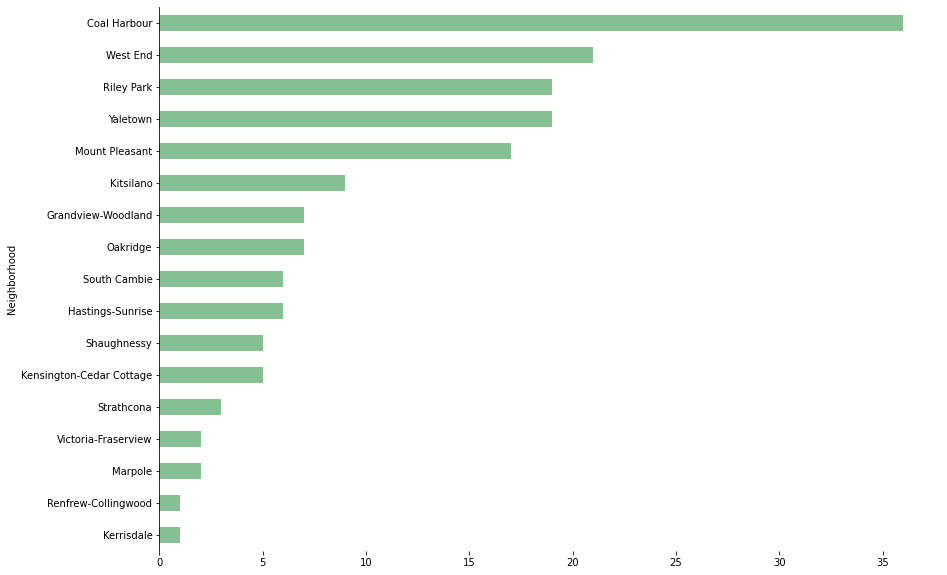

In [20]:
ax = Vancouver_Venues_restaurant.plot(figsize=(14, 10), x="Neighborhood", kind="barh", color='#86bf91')
#ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.get_legend().remove()
#ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="off", left="off", right="off", labelleft="on")
plt.savefig("#restaurants in each neighborhood.png", dpi=300)

Coal Harbour seems to be the most popular neighborhood for restaurants, followed by West End. Rileypark, Yaletown and Mount Pleasant are almost equally popular with 19, 18 and 16 number of restaurant venues, respectively. Kerrisdale is having the least number of restaurants. 

In [21]:
Vancouver_Venues_restaurant_df = Vancouver_Venues_restaurant.to_frame().reset_index()
Vancouver_Venues_restaurant_df.columns = ['Neighborhood', 'Number of Restaurant']
Vancouver_Venues_restaurant_df.index = np.arange(1, len(Vancouver_Venues_restaurant_df)+1)
list_rest_no = Vancouver_Venues_restaurant_df['Number of Restaurant'].to_list()
Neighborhood_names = Vancouver_Venues_restaurant_df['Neighborhood'].to_list()


In [22]:
#one hot encoding 
Vancouver_onehot = pd.get_dummies(Vancouver_Venues_only_restaurant[['Venue Category']], prefix ="", prefix_sep ="")

# add neighborhood column back to dataframe
Vancouver_onehot['Neighborhood'] = Vancouver_Venues_only_restaurant['Neighborhood']

#move neighborhood column to teh first column
fixed_columns = [Vancouver_onehot.columns[-1]] + list(Vancouver_onehot.columns[:-1])
Vancouver_onehot = Vancouver_onehot[fixed_columns]

Vancouver_onehot.head()

,Neighborhood,African Restaurant,American Restaurant,Asian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant,Hotpot Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Peruvian Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Shanghai Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
1,Grandview-Woodland,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Grandview-Woodland,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Grandview-Woodland,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Grandview-Woodland,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,Grandview-Woodland,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
# New dataframe size
Vancouver_onehot.shape

(166, 37)

### G. Grouping by neighborhoods and showing the mean of the frequency of occurence for each category of restaurants

In [24]:
Vancouver_grouped = Vancouver_onehot.groupby('Neighborhood').mean().reset_index()
Vancouver_grouped.shape
Vancouver_grouped

,Neighborhood,African Restaurant,American Restaurant,Asian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant,Hotpot Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Peruvian Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Shanghai Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Coal Harbour,0.027778,0.000000,0.027778,0.000000,0.000000,0.027778,0.027778,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.027778,0.055556,0.194444,0.083333,0.000000,0.000000,0.027778,0.027778,0.027778,0.000000,0.000000,0.138889,0.055556,0.055556,0.027778,0.000000,0.000000,0.0,0.083333,0.027778,0.000000,0.000000,0.027778
1,Grandview-Woodland,0.000000,0.000000,0.142857,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.142857,0.142857,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.142857,0.000000,0.000000,0.000000,0.000000
2,Hastings-Sunrise,0.000000,0.000000,0.166667,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.0,0.166667,0.000000,0.000000,0.000000,0.000000
3,Kensington-Cedar Cottage,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.200000,0.400000
4,Kerrisdale,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
5,Kitsilano,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.111111,0.0,0.111111,0.000000,0.111111,0.111111,0.111111
6,Marpole,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
7,Mount Pleasant,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.117647,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.058824,0.000000,0.058824,0.058824,0.058824,0.058824,0.000000,0.000000,0.000000,0.000000,0.0,0.176471,0.058824,0.000000,0.000000,0.176471
8,Oakridge,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.0,0.285714,0.000000,0.000000,0.000000,0.000000
9,Renfrew-Collingwood,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.

### H. Print the neighborhood with their respective top 10 most common venues 

In [25]:
num_top_venues = 10

for hood in Vancouver_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Vancouver_grouped[Vancouver_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Coal Harbour----
                 venue  freq
0  Japanese Restaurant  0.19
1     Ramen Restaurant  0.14
2     Sushi Restaurant  0.08
3    Korean Restaurant  0.08
4   Italian Restaurant  0.06
5   Seafood Restaurant  0.06
6           Restaurant  0.06
7   African Restaurant  0.03
8     Tapas Restaurant  0.03
9  Shanghai Restaurant  0.03


----Grandview-Woodland----
                       venue  freq
0          French Restaurant  0.14
1           Asian Restaurant  0.14
2         Chinese Restaurant  0.14
3           Sushi Restaurant  0.14
4       Fast Food Restaurant  0.14
5  Middle Eastern Restaurant  0.14
6         Italian Restaurant  0.14
7        Shanghai Restaurant  0.00
8        Peruvian Restaurant  0.00
9           Ramen Restaurant  0.00


----Hastings-Sunrise----
                       venue  freq
0           Malay Restaurant  0.17
1           Asian Restaurant  0.17
2         Chinese Restaurant  0.17
3           Sushi Restaurant  0.17
4       Fast Food Restaurant  0.17
5        

### I. Creating a panda dataframe

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Vancouver_grouped['Neighborhood']

for ind in np.arange(Vancouver_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Vancouver_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Coal Harbour,Japanese Restaurant,Ramen Restaurant,Sushi Restaurant,Korean Restaurant,Italian Restaurant,Seafood Restaurant,Restaurant,Vietnamese Restaurant,Mexican Restaurant,Asian Restaurant
1,Grandview-Woodland,Fast Food Restaurant,Italian Restaurant,Asian Restaurant,Sushi Restaurant,Chinese Restaurant,Middle Eastern Restaurant,French Restaurant,Vietnamese Restaurant,Indian Restaurant,Hotpot Restaurant
2,Hastings-Sunrise,Fast Food Restaurant,Asian Restaurant,Sushi Restaurant,Malay Restaurant,Chinese Restaurant,Restaurant,Vietnamese Restaurant,Indian Restaurant,Hotpot Restaurant,Greek Restaurant
3,Kensington-Cedar Cottage,Vietnamese Restaurant,Indian Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Eastern European Restaurant,Ethiopian Restaurant
4,Kerrisdale,Spanish Restaurant,Vietnamese Restaurant,Falafel Restaurant,Italian Restaurant,Indian Restaurant,Hotpot Restaurant,Greek Restaurant,French Restaurant,Fast Food Restaurant,Ethiopian Restaurant
5,Kitsilano,Vietnamese Restaurant,Southern / Soul Food Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,Chinese Restaurant,Restaurant,Sushi Restaurant,Thai Restaurant,Indian Restaurant,Asian Restaurant
6,Marpole,Restaurant,Vietnamese Restaurant,Korean Restaurant,Italian Restaurant,Indian Restaurant,Hotpot Restaurant,Greek Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant
7,Mount Pleasant,Vietnamese Restaurant,Sushi Restaurant,Indian Restaurant,Restaurant,Chinese Restaurant,Ethiopian Restaurant,Mexican Restaurant,New American Restaurant,Peruvian Restaurant,Ramen Restaurant
8,Oakridge,Sushi Restaurant,Fast Food Restaurant,Japanese Restaurant,Cantonese Restaurant,Restaurant,Falafel Restaurant,Italian Restaurant,Indian Restaurant,Hotpot Restaurant,Greek Restaurant
9,Renfrew-Collingwood,Malay Restaurant,Vietnamese Restaurant,Korean Restaurant,Italian Restaurant,Indian Restaurant,Hotpot Restaurant,Greek Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant


### J. Clustering the neighborhoods with k-means


In [28]:
#set number of clusters
kclusters = 5

Vancouver_grouped_clustering = Vancouver_grouped.drop('Neighborhood', 1)

#run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state=2).fit(Vancouver_grouped_clustering)

#check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 3, 3, 1, 4, 1, 0, 1, 3, 2], dtype=int32)

In [29]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Coal Harbour,Japanese Restaurant,Ramen Restaurant,Sushi Restaurant,Korean Restaurant,Italian Restaurant,Seafood Restaurant,Restaurant,Vietnamese Restaurant,Mexican Restaurant,Asian Restaurant
1,3,Grandview-Woodland,Fast Food Restaurant,Italian Restaurant,Asian Restaurant,Sushi Restaurant,Chinese Restaurant,Middle Eastern Restaurant,French Restaurant,Vietnamese Restaurant,Indian Restaurant,Hotpot Restaurant
2,3,Hastings-Sunrise,Fast Food Restaurant,Asian Restaurant,Sushi Restaurant,Malay Restaurant,Chinese Restaurant,Restaurant,Vietnamese Restaurant,Indian Restaurant,Hotpot Restaurant,Greek Restaurant
3,1,Kensington-Cedar Cottage,Vietnamese Restaurant,Indian Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Eastern European Restaurant,Ethiopian Restaurant
4,4,Kerrisdale,Spanish Restaurant,Vietnamese Restaurant,Falafel Restaurant,Italian Restaurant,Indian Restaurant,Hotpot Restaurant,Greek Restaurant,French Restaurant,Fast Food Restaurant,Ethiopian Restaurant
5,1,Kitsilano,Vietnamese Restaurant,Southern / Soul Food Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,Chinese Restaurant,Restaurant,Sushi Restaurant,Thai Restaurant,Indian Restaurant,Asian Restaurant
6,0,Marpole,Restaurant,Vietnamese Restaurant,Korean Restaurant,Italian Restaurant,Indian Restaurant,Hotpot Restaurant,Greek Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant
7,1,Mount Pleasant,Vietnamese Restaurant,Sushi Restaurant,Indian Restaurant,Restaurant,Chinese Restaurant,Ethiopian Restaurant,Mexican Restaurant,New American Restaurant,Peruvian Restaurant,Ramen Restaurant
8,3,Oakridge,Sushi Restaurant,Fast Food Restaurant,Japanese Restaurant,Cantonese Restaurant,Restaurant,Falafel Restaurant,Italian Restaurant,Indian Restaurant,Hotpot Restaurant,Greek Restaurant
9,2,Renfrew-Collingwood,Malay Restaurant,Vietnamese Restaurant,Korean Restaurant,Italian Restaurant,Indian Restaurant,Hotpot Restaurant,Greek Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant


In [30]:
Vancouver_merged = neighborhoods.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Vancouver_merged.dropna(inplace =True)
Vancouver_merged['Cluster Labels'] = Vancouver_merged['Cluster Labels'].astype(int)
Vancouver_merged

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Grandview-Woodland,49.28296,-123.06934,3,Fast Food Restaurant,Italian Restaurant,Asian Restaurant,Sushi Restaurant,Chinese Restaurant,Middle Eastern Restaurant,French Restaurant,Vietnamese Restaurant,Indian Restaurant,Hotpot Restaurant
1,Hastings-Sunrise,49.28021,-123.02869,3,Fast Food Restaurant,Asian Restaurant,Sushi Restaurant,Malay Restaurant,Chinese Restaurant,Restaurant,Vietnamese Restaurant,Indian Restaurant,Hotpot Restaurant,Greek Restaurant
2,Kensington-Cedar Cottage,49.24973,-123.06986,1,Vietnamese Restaurant,Indian Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Eastern European Restaurant,Ethiopian Restaurant
3,Kerrisdale,49.22097,-123.15073,4,Spanish Restaurant,Vietnamese Restaurant,Falafel Restaurant,Italian Restaurant,Indian Restaurant,Hotpot Restaurant,Greek Restaurant,French Restaurant,Fast Food Restaurant,Ethiopian Restaurant
5,Kitsilano,49.26833,-123.16542,1,Vietnamese Restaurant,Southern / Soul Food Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,Chinese Restaurant,Restaurant,Sushi Restaurant,Thai Restaurant,Indian Restaurant,Asian Restaurant
6,Marpole,49.20067,-123.13053,0,Restaurant,Vietnamese Restaurant,Korean Restaurant,Italian Restaurant,Indian Restaurant,Hotpot Restaurant,Greek Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant
7,Mount Pleasant,49.26178,-123.09608,1,Vietnamese Restaurant,Sushi Restaurant,Indian Restaurant,Restaurant,Chinese Restaurant,Ethiopian Restaurant,Mexican Restaurant,New American Restaurant,Peruvian Restaurant,Ramen Restaurant
8,Oakridge,49.23004,-123.12117,3,Sushi Restaurant,Fast Food Restaurant,Japanese Restaurant,Cantonese Restaurant,Restaurant,Falafel Restaurant,Italian Restaurant,Indian Restaurant,Hotpot Restaurant,Greek Restaurant
9,Renfrew-Collingwood,49.24970,-123.02975,2,Malay Restaurant,Vietnamese Restaurant,Korean Restaurant,Italian Restaurant,Indian Restaurant,Hotpot Restaurant,Greek Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant
10,Riley Park,49.25028,-123.10069,1,Restaurant,Japanese Restaurant,Thai Restaurant,Sushi Restaurant,Vegetarian / Vegan Restaurant,Hotpot Restaurant,Caribbean Restaurant,Chinese Restaurant,Seafood Restaurant,Malay Restaurant


Finally, let's visualize the resulting clusters.


In [31]:
#create a map with folium 
map_restaurants = folium.Map(location = [latitude, longitude], zoom_start=10)

# set color scheme for the five clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map 
for lat, lon, poi, cluster in zip(Vancouver_merged['Latitude'],
                                  Vancouver_merged['Longitude'],
                                 Vancouver_merged['Neighborhood'],
                                 Vancouver_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True) 
    folium.CircleMarker(
            [lat, lon],
            radius = 12,
            popup = label,
            color = rainbow[int(cluster)-1],
            fill = True,
            fill_color =rainbow[int(cluster)-1],
            fill_opacity = 0.7, parse_html = False).add_to(map_restaurants)

map_restaurants


### K. Examination of the 5 clusters.

#### Cluster 1

In [32]:
Vancouver_merged.loc[Vancouver_merged['Cluster Labels'] == 0]

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Marpole,49.20067,-123.13053,0,Restaurant,Vietnamese Restaurant,Korean Restaurant,Italian Restaurant,Indian Restaurant,Hotpot Restaurant,Greek Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant


#### Cluster 2


In [33]:
Vancouver_merged.loc[Vancouver_merged['Cluster Labels'] == 1]

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Kensington-Cedar Cottage,49.24973,-123.06986,1,Vietnamese Restaurant,Indian Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Eastern European Restaurant,Ethiopian Restaurant
5,Kitsilano,49.26833,-123.16542,1,Vietnamese Restaurant,Southern / Soul Food Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,Chinese Restaurant,Restaurant,Sushi Restaurant,Thai Restaurant,Indian Restaurant,Asian Restaurant
7,Mount Pleasant,49.26178,-123.09608,1,Vietnamese Restaurant,Sushi Restaurant,Indian Restaurant,Restaurant,Chinese Restaurant,Ethiopian Restaurant,Mexican Restaurant,New American Restaurant,Peruvian Restaurant,Ramen Restaurant
10,Riley Park,49.25028,-123.10069,1,Restaurant,Japanese Restaurant,Thai Restaurant,Sushi Restaurant,Vegetarian / Vegan Restaurant,Hotpot Restaurant,Caribbean Restaurant,Chinese Restaurant,Seafood Restaurant,Malay Restaurant
16,West End,49.28619,-123.13373,1,Ramen Restaurant,Restaurant,Korean Restaurant,Greek Restaurant,Japanese Restaurant,Sushi Restaurant,South Indian Restaurant,Indian Restaurant,Middle Eastern Restaurant,Fast Food Restaurant
18,Yaletown,49.27432,-123.12180,1,Italian Restaurant,Sushi Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Restaurant,French Restaurant,Indian Restaurant,Middle Eastern Restaurant,American Restaurant,Japanese Restaurant
19,Coal Harbour,49.29120,-123.12965,1,Japanese Restaurant,Ramen Restaurant,Sushi Restaurant,Korean Restaurant,Italian Restaurant,Seafood Restaurant,Restaurant,Vietnamese Restaurant,Mexican Restaurant,Asian Restaurant


I would rename Cluster 2 as 'Diverse' since there is a variety in cuisine which are popular in this cluster. 

#### Cluster 3

In [34]:
Vancouver_merged.loc[Vancouver_merged['Cluster Labels'] == 2]

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Renfrew-Collingwood,49.2497,-123.02975,2,Malay Restaurant,Vietnamese Restaurant,Korean Restaurant,Italian Restaurant,Indian Restaurant,Hotpot Restaurant,Greek Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant


#### Cluster 4

In [35]:
Vancouver_merged.loc[Vancouver_merged['Cluster Labels'] == 3]

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Grandview-Woodland,49.28296,-123.06934,3,Fast Food Restaurant,Italian Restaurant,Asian Restaurant,Sushi Restaurant,Chinese Restaurant,Middle Eastern Restaurant,French Restaurant,Vietnamese Restaurant,Indian Restaurant,Hotpot Restaurant
1,Hastings-Sunrise,49.28021,-123.02869,3,Fast Food Restaurant,Asian Restaurant,Sushi Restaurant,Malay Restaurant,Chinese Restaurant,Restaurant,Vietnamese Restaurant,Indian Restaurant,Hotpot Restaurant,Greek Restaurant
8,Oakridge,49.23004,-123.12117,3,Sushi Restaurant,Fast Food Restaurant,Japanese Restaurant,Cantonese Restaurant,Restaurant,Falafel Restaurant,Italian Restaurant,Indian Restaurant,Hotpot Restaurant,Greek Restaurant
11,Shaughnessy,49.25039,-123.12981,3,Sushi Restaurant,Malay Restaurant,Cantonese Restaurant,Greek Restaurant,Vietnamese Restaurant,Fast Food Restaurant,Italian Restaurant,Indian Restaurant,Hotpot Restaurant,French Restaurant
12,South Cambie,49.25010,-123.11999,3,Chinese Restaurant,Vietnamese Restaurant,Malay Restaurant,Sushi Restaurant,Cantonese Restaurant,Fast Food Restaurant,Italian Restaurant,Indian Restaurant,Hotpot Restaurant,Greek Restaurant
13,Strathcona,49.28009,-123.08024,3,Ethiopian Restaurant,Sushi Restaurant,Chinese Restaurant,Falafel Restaurant,Italian Restaurant,Indian Restaurant,Hotpot Restaurant,Greek Restaurant,French Restaurant,Fast Food Restaurant
15,Victoria-Fraserview,49.22027,-123.06941,3,Asian Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant,Fast Food Restaurant,Italian Restaurant,Indian Restaurant,Hotpot Restaurant,Greek Restaurant,French Restaurant,Falafel Restaurant


#### Cluster 5 

In [36]:
Vancouver_merged.loc[Vancouver_merged['Cluster Labels'] == 4]

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Kerrisdale,49.22097,-123.15073,4,Spanish Restaurant,Vietnamese Restaurant,Falafel Restaurant,Italian Restaurant,Indian Restaurant,Hotpot Restaurant,Greek Restaurant,French Restaurant,Fast Food Restaurant,Ethiopian Restaurant


#### That's all for now. Thanks for reading!